In [55]:
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [7]:
q = '''
    SELECT 
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price, room_type
    FROM 
        {db}.ldn_listings
    ORDER BY id
    '''

In [9]:
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test.head()

,price,room_type
0,65.0,Private room
1,100.0,Entire home/apt
2,300.0,Entire home/apt
3,150.0,Private room
4,65.0,Entire home/apt


In [10]:
q_test.shape[0]

85207

In [5]:
q_test.groupby('room_type', as_index=False).quantile(q=0.75)

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


К данным о цене и типе комнаты дополнительно выгружаю данные о рейтинге жилья (review_scores_rating). В запросе отфильтровываю пустые значения review_scores_rating и конвертирую эту колонку в тип float32.

In [19]:
q_2 = '''
    SELECT review_scores_rating, room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
    FROM 
        {db}.ldn_listings
    WHERE review_scores_rating !=''
    ORDER BY id
    LIMIT 1000
    '''

In [20]:
q_2_test = ph.read_clickhouse(query=q_2, connection=connection_default)
q_2_test.head()

,review_scores_rating,room_type,price
0,97.0,Private room,65.0
1,96.0,Entire home/apt,100.0
2,94.0,Entire home/apt,300.0
3,93.0,Entire home/apt,65.0
4,96.0,Private room,29.0


In [21]:
q_2_test.review_scores_rating = q_2_test.review_scores_rating.astype('float')
q_2_test

,review_scores_rating,room_type,price
0,97.0,Private room,65.0
1,96.0,Entire home/apt,100.0
2,94.0,Entire home/apt,300.0
3,93.0,Entire home/apt,65.0
4,96.0,Private room,29.0
...,...,...,...
995,100.0,Entire home/apt,165.0
996,93.0,Private room,99.0
997,100.0,Private room,45.0
998,88.0,Private room,20.0


In [22]:
# группирую датафрейм по типу жилья и считаю среднее для цены и рейтинга 
s = q_2_test.groupby('room_type').price.mean().to_frame().reset_index()
s

,room_type,price
0,Entire home/apt,135.882950
1,Hotel room,134.000000
2,Private room,54.642437
3,Shared room,21.000000


In [23]:
m = q_2_test.groupby('room_type').review_scores_rating.mean().to_frame().reset_index()
m

,room_type,review_scores_rating
0,Entire home/apt,93.568789
1,Hotel room,92.500000
2,Private room,94.766208
3,Shared room,90.000000


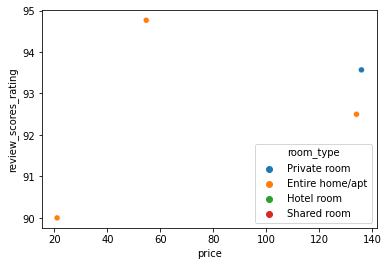

In [25]:
# строю график рассеивания средней цены и рейтинга c разбивкой по типу жилья 
sns.scatterplot(data = q_2_test, x = s.price, y = m.review_scores_rating, hue = 'room_type')

In [26]:
q_3 = '''
    SELECT host_id, host_verifications
    FROM 
        {db}.ldn_listings
    WHERE experiences_offered != 'none'
    
    '''

In [28]:
q_3_test = ph.read_clickhouse(query=q_3, connection=connection_default)
q_3_test = q_3_test.drop_duplicates()
q_3_test.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [30]:
q_3_test.host_verifications = q_3_test.host_verifications.apply(lambda x: x.split(','))

In [32]:
q_3_test.explode('host_verifications').host_verifications.value_counts().to_frame(name='count')
# считаю, сколько раз встречается каждый способ верификации

,count
['email',1345
'phone',1322
'reviews',1201
'jumio',1114
'government_id'],755
'offline_government_id',469
'government_id',441
'work_email'],279
'facebook',266
'selfie',251


Посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Группирую данные по району и виду впечатления и считаю количество объявлений.

In [36]:
q_4 = '''
    SELECT experiences_offered,
       neighbourhood_cleansed,
       COUNT(id) AS experiences_count
    FROM ldn_listings
    WHERE experiences_offered != 'none'
    GROUP BY experiences_offered, neighbourhood_cleansed
    ORDER BY experiences_count DESC
    LIMIT 100
    
    '''

In [37]:
q_4_test = ph.read_clickhouse(query=q_4, connection=connection_default)
q_4_test.head()

,experiences_offered,neighbourhood_cleansed,experiences_count
0,family,Hackney,61
1,business,Tower Hamlets,58
2,business,Westminster,50
3,social,Hackney,49
4,business,Hammersmith and Fulham,48


In [38]:
# преобразую таблицу для последующей визуализации
q_4_test = q_4_test.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
q_4_test.head()

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0


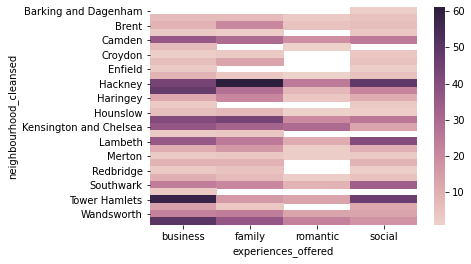

In [19]:
cmap=sns.cubehelix_palette(as_cmap=True)
ax = sns.heatmap(q_4_test, cmap=cmap)

Выгружаю данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. 

In [39]:
q_5 = '''
    SELECT room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr
    FROM ldn_listings
    WHERE experiences_offered != 'none'
    LIMIT 1000
    '''

In [40]:
q_5_test = ph.read_clickhouse(query=q_5, connection=connection_default)
q_5_test.head()

,room_type,price_corr
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


Строю два графика:
На первом отображаю исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())

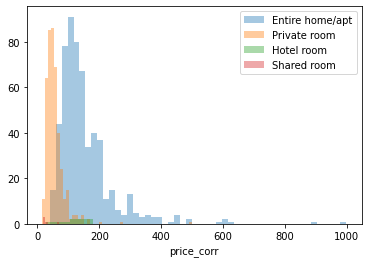

In [58]:
sns.distplot(q_5_test.query('room_type == "Entire home/apt"').price_corr, kde=False, label='Entire home/apt')
sns.distplot(q_5_test.query('room_type == "Private room"').price_corr, kde=False, label='Private room')
sns.distplot(q_5_test.query('room_type == "Hotel room"').price_corr, kde=False, label='Hotel room')
sns.distplot(q_5_test.query('room_type == "Shared room"').price_corr, kde=False, label='Shared room')
plt.legend()
plt.show()

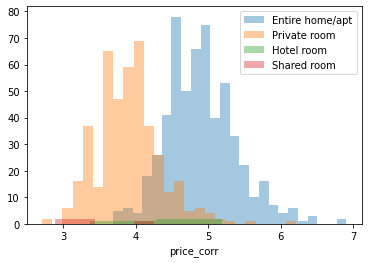

In [59]:
sns.distplot(np.log(q_5_test.query('room_type == "Entire home/apt"').price_corr), kde=False, label='Entire home/apt')
sns.distplot(np.log(q_5_test.query('room_type == "Private room"').price_corr), kde=False, label='Private room')
sns.distplot(np.log(q_5_test.query('room_type == "Hotel room"').price_corr), kde=False, label='Hotel room')
sns.distplot(np.log(q_5_test.query('room_type == "Shared room"').price_corr), kde=False, label='Shared room')
plt.legend()
plt.show()

Выгружаю данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. 

In [77]:
q_6 = '''
    SELECT room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr,
        toDate(first_review) AS f_r
    FROM ldn_listings
    WHERE first_review > '2010-01-01'
    LIMIT 1000
    '''

In [78]:
q_6_test = ph.read_clickhouse(query=q_6, connection=connection_default)
q_6_test.head()

,room_type,price_corr,f_r
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [79]:
q_6_test.dtypes

room_type             object
price_corr           float32
f_r           datetime64[ns]
dtype: object

In [80]:
q_6_test.f_r = q_6_test.f_r.dt.year

In [82]:
q_6_test.head()

,room_type,price_corr,f_r
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010


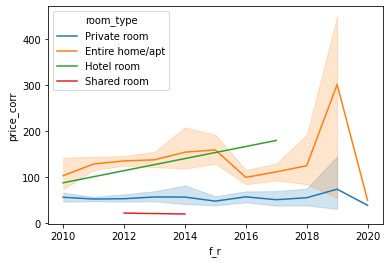

In [84]:
# Строю график динамики цен на жилье в зависимости от типа комнаты по годам
sns.lineplot(data=q_6_test, x='f_r', y='price_corr', hue='room_type')